In [31]:
import pandas as pd

In [32]:
data = []
for i in range(10):
    row = pd.read_csv(f"temp_dir/{i}.csv")
    data.append(row)
data = pd.concat(data)
data

,epoch,train_loss,train_auc,train_acc,val_loss,val_auc,val_acc,test_auc,test_acc,optimal_threshold,f1_macro
0,6,0.562036,0.786245,0.722322,0.543330,0.806592,0.755020,0.754671,0.690516,0.52,0.689794
0,6,0.556691,0.791405,0.711712,0.589976,0.762267,0.741036,0.750894,0.690516,0.39,0.684498
0,8,0.534546,0.810624,0.740359,0.537493,0.766823,0.726141,0.758314,0.702163,0.43,0.698067
0,7,0.549133,0.798226,0.728552,0.584684,0.758719,0.697761,0.757554,0.690516,0.56,0.690508
0,7,0.546684,0.801989,0.737690,0.588177,0.739025,0.649789,0.759174,0.705491,0.44,0.704180
0,2,0.614489,0.732261,0.684211,0.680603,0.616850,0.584677,0.729841,0.675541,0.50,0.673948
0,7,0.553465,0.793877,0.729851,0.526742,0.804351,0.752000,0.747195,0.693844,0.40,0.693129
0,8,0.538679,0.806545,0.738600,0.593240,0.749509,0.703125,0.758347,0.700499,0.54,0.700432
0,7,0.550329,0.795598,0.720089,0.559837,0.784408,0.735931,0.758940,0.697171,0.52,0.696868
0,13,0.524441,0.818715,0.748095,0.540084,0.806202,0.725000,0.762795,0.700499,0.50,0.699360


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: ylabel='val_auc'>

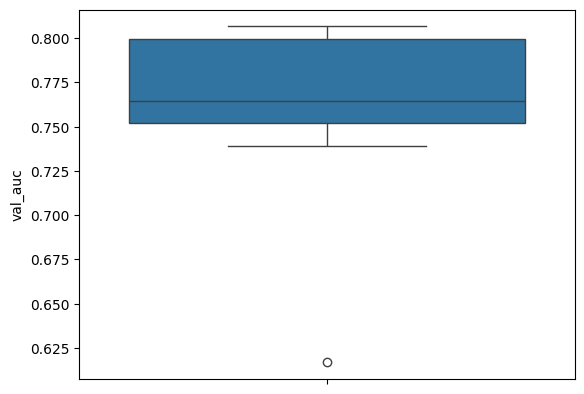

In [34]:
sns.boxplot(data, y="val_auc")

<Axes: ylabel='test_auc'>

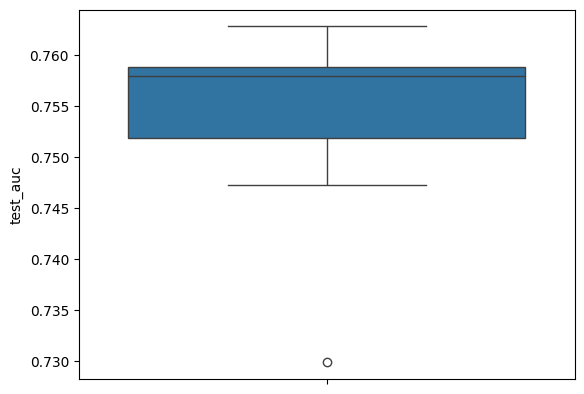

In [35]:
sns.boxplot(data, y="test_auc")

In [36]:
import torch
import numpy as np
import os
import h5py
from pathlib import Path
from histomil.models import ABMIL
from histomil.utils import get_embed_dim, seed_torch
from histomil.datasets import H5Dataset
import pandas as pd

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_torch(2)

# Parámetros (ajusta según tu configuración)
checkpoint_path = "temp_dir/0-checkpoint.pt"
print(os.path.exists(checkpoint_path))
pretrained_model = "uni_v2"  # Ajusta según tu modelo
embed_dim = get_embed_dim(pretrained_model)
features_path = os.path.expanduser("~/processed_data/trident/tcga-brca/20x_256px_0px_overlap/features_uni_v2/")
csv_path = "./splits/class_MKI67/dataset.csv"
splits_dir = "../HistologyLinearProbing/results_mki67_class/splits/MKI67/"

print(f"Device: {device}")
print(f"Embedding dimension: {embed_dim}")


True
Device: cuda
Embedding dimension: 1536


In [37]:
# Cargar el modelo
model = ABMIL(input_feature_dim=embed_dim, n_heads = 4, dropout=0.2, hidden_dim=512).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print("Modelo cargado exitosamente")


Modelo cargado exitosamente


In [38]:
# Cargar dataset y seleccionar una slide
fold = 0  # Ajusta según el fold que quieras usar
dataset_csv = pd.read_csv(csv_path)
splits = pd.read_csv(f"{splits_dir}/splits_{fold}_bool.csv")
splits.columns = ["slide_id", "train", "val", "test"]
dataset_csv = dataset_csv.merge(splits, on="slide_id")

# Seleccionar una slide del test set (puedes cambiar a "train" o "val")
test_slides = dataset_csv[dataset_csv["test"]]
print(f"Total slides en test: {len(test_slides)}")

# Seleccionar la primera slide del test set (puedes cambiar el índice)
slide_idx = 3
selected_slide = test_slides.iloc[slide_idx]
slide_id = selected_slide['slide_id']
label = selected_slide['label']

print(f"Slide seleccionado: {slide_id}")
print(f"Label: {label}")


Total slides en test: 601
Slide seleccionado: TCGA-AO-A0JJ-01Z-00-DX1.D5B636F5-1B47-4033-9938-9DC8CD48CEE9.svs
Label: 1


In [39]:
# Cargar features de la slide
def drop_extension(filepath):
    filename = Path(filepath)
    return filename.stem

h5_file = os.path.join(features_path, drop_extension(slide_id) + '.h5')
with h5py.File(h5_file, "r") as f:
    features = f["features"][:]  # Shape: (num_patches, feature_dim)

features_tensor = torch.from_numpy(features).float().to(device)
features_tensor = features_tensor.unsqueeze(0)  # Agregar dimensión de batch: (1, num_patches, feature_dim)

print(f"Shape de features: {features_tensor.shape}")
print(f"Número de parches: {features_tensor.shape[1]}")


Shape de features: torch.Size([1, 28910, 1536])
Número de parches: 28910


In [40]:
# DEBUG: Verificar qué devuelve el feature_encoder directamente
print("=== DEBUG: Verificando feature_encoder ===")
batch = {'features': features_tensor}
result = model.feature_encoder(batch, return_raw_attention=True)
print(f"Tipo de resultado: {type(result)}")
if isinstance(result, tuple):
    print(f"Longitud de tupla: {len(result)}")
    print(f"Tipo elemento 0: {type(result[0])}, Shape: {result[0].shape if hasattr(result[0], 'shape') else 'N/A'}")
    print(f"Tipo elemento 1: {type(result[1])}, Shape: {result[1].shape if hasattr(result[1], 'shape') else 'N/A'}")
    if result[1] is not None:
        print(f"Valores únicos en attention_scores: {torch.unique(result[1])}")
        print(f"Suma de attention_scores: {result[1].sum()}")
else:
    print(f"Resultado no es tupla: {result}")

# Intentar acceder directamente al image_pooler
print("\n=== DEBUG: Accediendo directamente a image_pooler ===")
image_pooler = model.feature_encoder.model['image_pooler']
print(f"image_pooler type: {type(image_pooler)}")
print(f"image_pooler attributes: {dir(image_pooler)}")

# Obtener attention scores
with torch.no_grad():
    logits, attention_scores = model(features_tensor, return_raw_attention=True)

# attention_scores shape: [batch_size, n_branches, n_heads, num_patches]
print(f"\nShape de attention_scores: {attention_scores.shape}")
print(f"Tipo de attention_scores: {type(attention_scores)}")
print(f"Valores únicos: {torch.unique(attention_scores)}")
print(f"¿Es None?: {attention_scores is None}")

# Convertir a numpy
attention_scores_np = attention_scores.cpu().numpy()

# Para visualización, promediamos sobre branches y heads si hay múltiples
# Shape final: (num_patches,)
if attention_scores_np.shape[1] > 1 or attention_scores_np.shape[2] > 1:
    # Promediar sobre branches y heads
    attention_avg = attention_scores_np[0].mean(axis=(0, 1))  # Promedio sobre branches y heads
else:
    attention_avg = attention_scores_np[0, 0, 0, :]  # Tomar el único branch y head

print(f"Shape final de atención: {attention_avg.shape}")
print(f"Suma de atención (debería ser ~1.0): {attention_avg.sum():.6f}")
print(f"Min: {attention_avg.min():.6f}, Max: {attention_avg.max():.6f}, Mean: {attention_avg.mean():.6f}")


=== DEBUG: Verificando feature_encoder ===
Tipo de resultado: <class 'tuple'>
Longitud de tupla: 2
Tipo elemento 0: <class 'torch.Tensor'>, Shape: torch.Size([1, 1536])
Tipo elemento 1: <class 'torch.Tensor'>, Shape: torch.Size([1, 1, 4, 28910])
Valores únicos en attention_scores: tensor([-0.0826, -0.0801, -0.0795,  ...,  0.1281,  0.1314,  0.1346],
       device='cuda:0')
Suma de attention_scores: 1489.72412109375

=== DEBUG: Accediendo directamente a image_pooler ===
image_pooler type: <class 'trident.slide_encoder_models.model_zoo.reusable_blocks.ABMIL.ABMIL'>
image_pooler attributes: ['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '

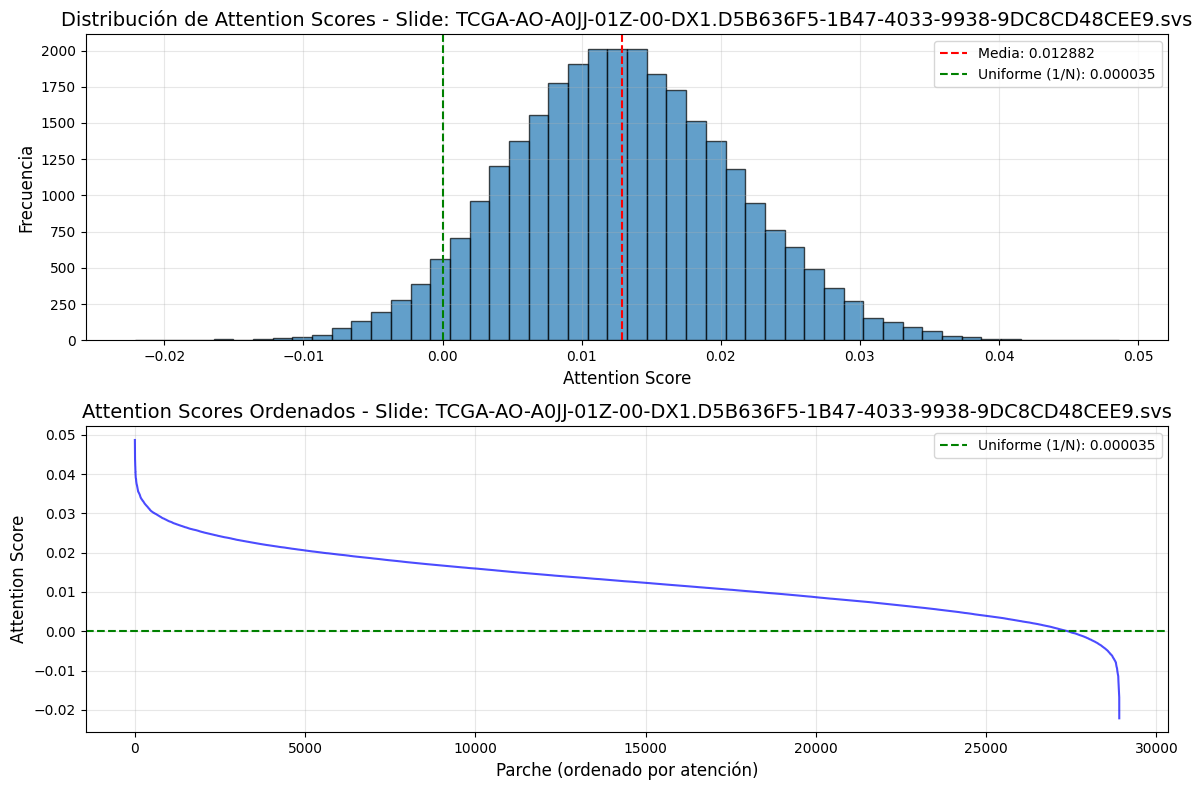


Top 10 parches con mayor atención:
  1. Parche 23671: 0.0486454405
  2. Parche 25825: 0.0464175940
  3. Parche 23621: 0.0454581194
  4. Parche 23935: 0.0450268984
  5. Parche 20252: 0.0445226505
  6. Parche 27905: 0.0436121523
  7. Parche 27896: 0.0435282588
  8. Parche 27422: 0.0427254625
  9. Parche 11248: 0.0425443612
  10. Parche 12978: 0.0421759710


In [41]:
# Plotear attention scores
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Histograma de attention scores
axes[0].hist(attention_avg, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Attention Score', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title(f'Distribución de Attention Scores - Slide: {slide_id}', fontsize=14)
axes[0].axvline(attention_avg.mean(), color='red', linestyle='--', label=f'Media: {attention_avg.mean():.6f}')
axes[0].axvline(1.0/len(attention_avg), color='green', linestyle='--', 
                label=f'Uniforme (1/N): {1.0/len(attention_avg):.6f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Attention scores ordenados
sorted_indices = np.argsort(attention_avg)[::-1]  # Ordenar de mayor a menor
sorted_attention = attention_avg[sorted_indices]

axes[1].plot(range(len(sorted_attention)), sorted_attention, 'b-', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Parche (ordenado por atención)', fontsize=12)
axes[1].set_ylabel('Attention Score', fontsize=12)
axes[1].set_title(f'Attention Scores Ordenados - Slide: {slide_id}', fontsize=14)
axes[1].axhline(1.0/len(attention_avg), color='green', linestyle='--', 
                label=f'Uniforme (1/N): {1.0/len(attention_avg):.6f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Información adicional
print(f"\nTop 10 parches con mayor atención:")
top_10_indices = sorted_indices[:10]
for i, idx in enumerate(top_10_indices):
    print(f"  {i+1}. Parche {idx}: {attention_avg[idx]:.10f}")


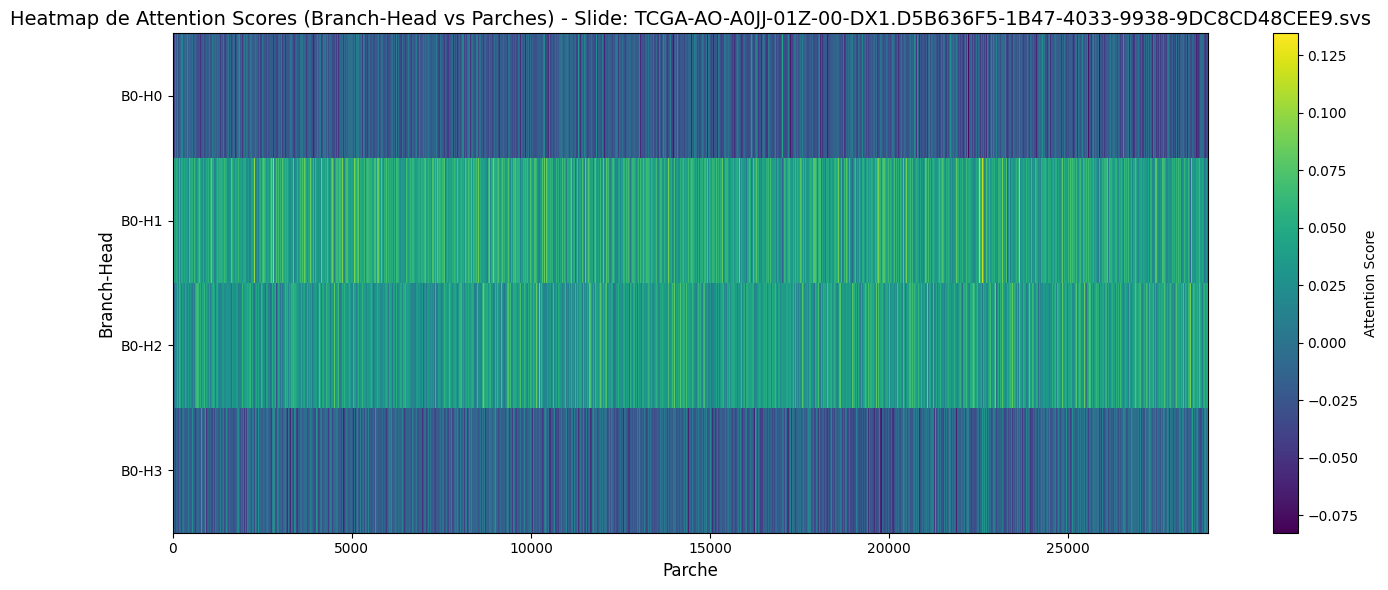


Resumen por Branch-Head:
  Branch 0, Head 0: Min=-0.082555, Max=0.057645, Mean=-0.018522, Sum=-535.472473
  Branch 0, Head 1: Min=-0.029058, Max=0.134612, Mean=0.046422, Sum=1342.062012
  Branch 0, Head 2: Min=-0.048720, Max=0.128115, Mean=0.037566, Sum=1086.039062
  Branch 0, Head 3: Min=-0.080101, Max=0.069184, Mean=-0.013937, Sum=-402.904541


In [42]:
# Plot adicional: Heatmap de attention scores si hay múltiples branches/heads
if attention_scores_np.shape[1] > 1 or attention_scores_np.shape[2] > 1:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Crear matriz: rows = branches*heads, cols = patches
    n_branches = attention_scores_np.shape[1]
    n_heads = attention_scores_np.shape[2]
    n_patches = attention_scores_np.shape[3]
    
    # Reshape para el heatmap
    attention_matrix = attention_scores_np[0].reshape(n_branches * n_heads, n_patches)
    
    im = ax.imshow(attention_matrix, aspect='auto', cmap='viridis', interpolation='nearest')
    ax.set_xlabel('Parche', fontsize=12)
    ax.set_ylabel('Branch-Head', fontsize=12)
    ax.set_title(f'Heatmap de Attention Scores (Branch-Head vs Parches) - Slide: {slide_id}', fontsize=14)
    
    # Crear labels para branches y heads
    y_labels = []
    for b in range(n_branches):
        for h in range(n_heads):
            y_labels.append(f'B{b}-H{h}')
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)
    
    plt.colorbar(im, ax=ax, label='Attention Score')
    plt.tight_layout()
    plt.show()
    
    print(f"\nResumen por Branch-Head:")
    for b in range(n_branches):
        for h in range(n_heads):
            branch_head_attn = attention_scores_np[0, b, h, :]
            print(f"  Branch {b}, Head {h}: Min={branch_head_attn.min():.6f}, "
                  f"Max={branch_head_attn.max():.6f}, Mean={branch_head_attn.mean():.6f}, "
                  f"Sum={branch_head_attn.sum():.6f}")


In [43]:
from trident import OpenSlideWSI, visualize_heatmap

# Usar datos ya cargados en celdas anteriores:
# - slide_id: de la celda 7
# - attention_avg: de la celda 9 (attention scores promediados)
# - h5_file: ruta al archivo de features de la celda 8

# Configurar directorio de salida
job_dir = './heatmap_viz'
os.makedirs(job_dir, exist_ok=True)

# Construir rutas basadas en slide_id
slide_stem = drop_extension(slide_id)

# Ruta al archivo WSI (ajusta según tu estructura de datos)
# Opción 1: Si tienes la ruta base de datos
data_base_path = os.path.expanduser('~/tcga_gdc/images/tcga_brca')
slide_path = os.path.join(data_base_path, slide_id)

# Opción 2: Si el slide está en otro lugar, ajusta esta ruta
# slide_path = f'/ruta/a/tus/slides/{slide_id}'

# Ruta al archivo de patches para obtener coordenadas
# Ajusta según tu estructura de datos
patches_base_path = os.path.expanduser("~/processed_data/trident/tcga-brca/20x_256px_0px_overlap/patches/")
coords_path = os.path.join(patches_base_path, slide_stem + '_patches.h5')

print(f"Slide path: {slide_path}")
print(f"Coords path: {coords_path}")
print(f"Features path: {h5_file}")

# Verificar que los archivos existen
if not os.path.exists(slide_path):
    print(f"WARNING: Slide file not found at {slide_path}")
    print("Por favor, ajusta la ruta en slide_path")
if not os.path.exists(coords_path):
    print(f"WARNING: Coords file not found at {coords_path}")
    print("Intentando cargar coordenadas desde el archivo de features...")
    # Intentar cargar coordenadas desde el archivo de features
    with h5py.File(h5_file, 'r') as f:
        if 'coords' in f:
            coords = f['coords'][:]
            coords_attrs = dict(f['coords'].attrs)
            print("Coordenadas cargadas desde archivo de features")
        else:
            raise FileNotFoundError(f"No se encontraron coordenadas en {h5_file} ni en {coords_path}")
else:
    # Cargar coordenadas desde archivo de patches
    with h5py.File(coords_path, 'r') as f:
        coords = f['coords'][:]
        coords_attrs = dict(f['coords'].attrs)

# Cargar WSI
if os.path.exists(slide_path):
    slide = OpenSlideWSI(slide_path=slide_path, lazy_init=False)
    
    # Usar attention_avg ya calculado (de la celda 9)
    # Asegurarse de que tiene la forma correcta: (num_patches,)
    scores = attention_avg
    
    print(f"Shape de scores: {scores.shape}")
    print(f"Shape de coords: {coords.shape}")
    print(f"Coords attrs: {coords_attrs}")
    
    # Verificar que el número de parches coincide
    if len(scores) != len(coords):
        print(f"WARNING: Número de scores ({len(scores)}) no coincide con número de coordenadas ({len(coords)})")
        # Tomar el mínimo para evitar errores
        min_len = min(len(scores), len(coords))
        scores = scores[:min_len]
        coords = coords[:min_len]
        print(f"Ajustado a {min_len} parches")
    
    # Generar heatmap
    heatmap_save_path = visualize_heatmap(
        wsi=slide,
        scores=scores,  
        coords=coords,
        vis_level=1,
        patch_size_level0=coords_attrs.get('patch_size_level0', 256),  # Valor por defecto si no existe
        normalize=True,
        num_top_patches_to_save=10,
        output_dir=job_dir
    )
    
    print(f"Heatmap guardado en: {heatmap_save_path}")
else:
    print("No se pudo generar el heatmap porque el archivo WSI no existe.")
    print("Por favor, verifica la ruta del slide y ajusta 'slide_path' en esta celda.")


Slide path: /mnt/beegfs/home/g.cabas/tcga_gdc/images/tcga_brca/TCGA-AO-A0JJ-01Z-00-DX1.D5B636F5-1B47-4033-9938-9DC8CD48CEE9.svs
Coords path: /mnt/beegfs/home/g.cabas/processed_data/trident/tcga-brca/20x_256px_0px_overlap/patches/TCGA-AO-A0JJ-01Z-00-DX1.D5B636F5-1B47-4033-9938-9DC8CD48CEE9_patches.h5
Features path: /mnt/beegfs/home/g.cabas/processed_data/trident/tcga-brca/20x_256px_0px_overlap/features_uni_v2/TCGA-AO-A0JJ-01Z-00-DX1.D5B636F5-1B47-4033-9938-9DC8CD48CEE9.h5
Shape de scores: (28910,)
Shape de coords: (28910, 2)
Coords attrs: {'level0_magnification': np.int64(20), 'name': 'TCGA-AO-A0JJ-01Z-00-DX1.D5B636F5-1B47-4033-9938-9DC8CD48CEE9', 'overlap': np.int64(0), 'patch_size': np.int64(256), 'patch_size_level0': np.int64(256), 'savetodir': '/mnt/beegfs/labs/DiGenomaLab/Machine_Learning/cancer_histology/processed_data/trident/tcga-brca/20x_256px_0px_overlap', 'target_magnification': np.int64(20)}
Heatmap guardado en: ./heatmap_viz/heatmap.png
